In [72]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time

# Import classifiers to test
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Import metrics to analyze results
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Import functions for cross validation and parameter optimization
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

In [73]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',
       'exercised_stock_options', 'bonus', 'restricted_stock',
       'shared_receipt_with_poi', 'restricted_stock_deferred',
       'total_stock_value', 'expenses', 'loan_advances', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'director_fees',
       'deferred_income', 'long_term_incentive',
       'from_poi_to_this_person']

In [74]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [75]:
len(data_dict.keys())

146

In [76]:
for item in data_dict['METTS MARK'].keys():
    print item
print len(data_dict['METTS MARK'].keys())

salary
to_messages
deferral_payments
total_payments
exercised_stock_options
bonus
restricted_stock
shared_receipt_with_poi
restricted_stock_deferred
total_stock_value
expenses
loan_advances
from_messages
other
from_this_person_to_poi
poi
director_fees
deferred_income
long_term_incentive
email_address
from_poi_to_this_person
21


### Number of data points
Number of POI vs. Non-POI

In [77]:
print 'DATA POINTS'
print '==========='
print len(data_dict), 'total data points'
count_poi = 0
for person in data_dict:
	if data_dict[person]['poi'] == 1:
		count_poi += 1
print count_poi, 'POI;	', len(data_dict) - count_poi, 'non-POI'

DATA POINTS
146 total data points
18 POI;	128 non-POI


### Convert all 'str' and 'int' types to 'float' type

In [78]:
df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.replace('NaN',np.nan)
df = df.drop('email_address', 1)

# Convert NaN to Median Value
df = df.apply(lambda x: x.fillna(x.median()), axis=0)

# Create new features
# Fraction from poi
df['fraction_from_poi'] = df['from_poi_to_this_person']/df['from_messages']
features_list.append('fraction_from_poi')
# Fraction to poi
df['fraction_to_poi'] = df['from_this_person_to_poi']/df['to_messages']
features_list.append('fraction_to_poi')

data_dict = df.T.to_dict()

### Number of Features
Split by type

In [79]:
print 'FEATURES'
print '========'
first_key = data_dict.keys()[0]
print len(data_dict[first_key].keys()), 'features total'
print
print 'Feature breakdown:'
data_types = defaultdict(list)
for key in data_dict[first_key].keys():
	data_type = type(data_dict[first_key][key])
	data_types[data_type].append(key)
print
print 'Data Types:'
for key in data_types:
	print key,':'
#	for item in data_types[key]:
#		print '   ', item
	print data_types[key]
	print '------------'

print np.isnan(data_dict['LOCKHART EUGENE E']['salary'])

FEATURES
22 features total

Feature breakdown:

Data Types:
<type 'float'> :
['to_messages', 'deferral_payments', 'expenses', 'long_term_incentive', 'from_poi_to_this_person', 'deferred_income', 'fraction_from_poi', 'restricted_stock_deferred', 'shared_receipt_with_poi', 'loan_advances', 'from_messages', 'other', 'director_fees', 'bonus', 'total_stock_value', 'from_this_person_to_poi', 'restricted_stock', 'salary', 'total_payments', 'fraction_to_poi', 'exercised_stock_options']
------------
<type 'bool'> :
['poi']
------------
False


### Number of NaN values

In [80]:
print 'MISSING DATA (NaN)'
print '=================='
print 'Count of NaN Values (for each feature) :'
print
# Initialize Counts:
count_nan = defaultdict(int)
for key in data_dict[first_key].keys():
	count_nan[key] = 0
# Increment Counter
for person in data_dict:
	for key in data_dict[person].keys():
		if np.isnan(data_dict[person][key]):
			count_nan[key] += 1
# Sort dictionary by value and print values
for key in sorted(count_nan, key=count_nan.get, reverse=True):
  print key, count_nan[key]

print 
print
print 'NaN by Data Point'
print '================='
count_nan_ind = defaultdict(int)
for person in data_dict:
	cnt = 0
	for key in data_dict[person].keys():
		if np.isnan(data_dict[person][key]):
			cnt += 1
	count_nan_ind[person] = cnt

for key in sorted(count_nan_ind, key = count_nan_ind.get, reverse=True)[0:14]:
	print key, count_nan_ind[key]

MISSING DATA (NaN)
Count of NaN Values (for each feature) :

to_messages 0
deferral_payments 0
expenses 0
poi 0
deferred_income 0
long_term_incentive 0
fraction_from_poi 0
restricted_stock_deferred 0
shared_receipt_with_poi 0
loan_advances 0
from_messages 0
other 0
director_fees 0
bonus 0
total_stock_value 0
from_poi_to_this_person 0
from_this_person_to_poi 0
restricted_stock 0
salary 0
total_payments 0
fraction_to_poi 0
exercised_stock_options 0


NaN by Data Point
METTS MARK 0
BAXTER JOHN C 0
ELLIOTT STEVEN 0
CORDES WILLIAM R 0
HANNON KEVIN P 0
MORDAUNT KRISTINA M 0
MEYER ROCKFORD G 0
MCMAHON JEFFREY 0
HAEDICKE MARK E 0
PIPER GREGORY F 0
HUMPHREY GENE E 0
NOLES JAMES L 0
BLACHMAN JEREMY M 0
SUNDE MARTIN 0


### Remove Outliers
'TOTAL'

'THE TRAVEL AGENCY IN THE PARK'

'LOCKHART EUGENE E'

In [81]:
outliers = ['TOTAL','THE TRAVEL AGENCY IN THE PARK','LOCKHART EUGENE E']
print 'Initial Length:', len(data_dict)
for name in outliers:
    data_dict.pop(name)
print 'Length after Outlier Removal:', len(data_dict)

Initial Length: 146
Length after Outlier Removal: 143


### Feature Selection
Use K-Best

In [86]:

data = featureFormat(data_dict, features_list, sort_keys=True)
labels, features = targetFeatureSplit(data)

### Feature scaling
from sklearn import preprocessing
features = preprocessing.MinMaxScaler().fit_transform(features)

### SelectKBest
selection = SelectKBest(k = 'all')
selection.fit(features, labels)
scores = selection.scores_
score_pairs = zip(features_list[1:], scores)
score_pairs = sorted(score_pairs, key = lambda x: x[1])
score_pairs.reverse()

k_best_features = dict(score_pairs[0:6], )
k_best_features

{'bonus': 15.646310196119428,
 'deferred_income': 10.183117569139776,
 'exercised_stock_options': 27.19264248325241,
 'poi': inf,
 'salary': 10.806071863124094,
 'total_stock_value': 23.428992663609957}

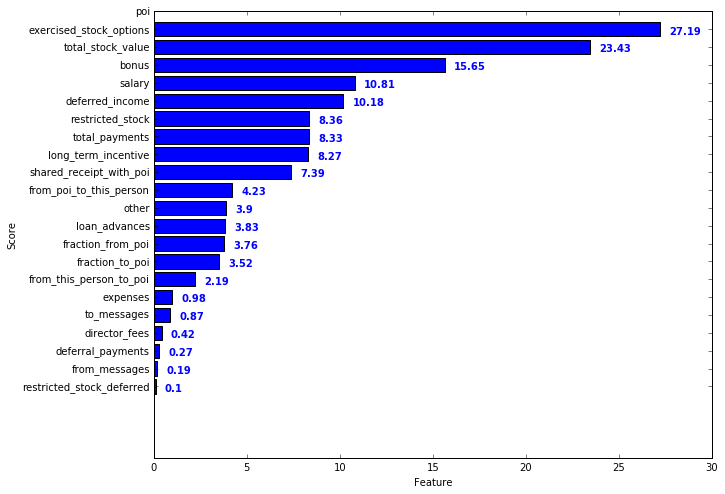

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline  
features_names = zip(*score_pairs)[0]
score = zip(*score_pairs)[1]
x_pos = np.arange(len(features_names)) 


plt.figure(figsize=(10,8))
plt.barh(x_pos, score, align='center')
plt.yticks(x_pos, features_names) 
plt.ylabel('Score')
plt.xlabel('Feature')
plt.gca().invert_yaxis()
for i, v in enumerate(score[1:]):
    v = float("{0:.2f}".format(v))
    plt.text(v + .5, i + 1.25, str(v), color='blue', fontweight='bold')
plt.show()